In [37]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os

#import for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt



#for Modelling/timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf


from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

sns.set(rc={'figure.figsize':(20,15)})


#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

    

In [2]:
# load cleaned data time series:
df_time_m = pd.read_csv('timeseriesformodel.csv')

# Benchmark Forecasting

#### Naive Forecast/Persistence algorithm

As baseline method we use the persistence algorithm. It uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).


In [3]:
df_time_m.head()

,date,country,daily_vaccinations,dayvacc_Detrend
0,2021-02-23,Afghanistan,1367.0,NaN
1,2021-02-24,Afghanistan,1367.0,NaN
2,2021-02-25,Afghanistan,1367.0,NaN
3,2021-02-26,Afghanistan,1367.0,NaN
4,2021-02-27,Afghanistan,1367.0,NaN


In [4]:
df_time_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7891 entries, 0 to 7890
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                7891 non-null   object 
 1   country             7891 non-null   object 
 2   daily_vaccinations  7891 non-null   float64
 3   dayvacc_Detrend     7861 non-null   float64
dtypes: float64(2), object(2)
memory usage: 246.7+ KB


In [5]:
df_time_m['date']= pd.to_datetime(df_time_m['date'])
df_time_wo_detrend = df_time_m[['date','daily_vaccinations']]
df_time_wo_detrend.set_index('date', inplace = True)
df_time_wo_detrend.to_csv('df_time_wo_detrend.csv', encoding='utf-8', index=False)

In [26]:
# Create lagged dataset
#dataframe = pd.concat([df_time_wo_detrend['daily_vaccinations'].shift(periods = 1)], axis =1)
#values = series.values
#dataframe = pd.concat([values.shift(1), values], axis=1)
#dataframe.columns = ['t-1', 't+1']
#print(dataframe.head(5))

In [28]:
# Create lagged dataset
df_time_wo_detrend = df_time_m[['daily_vaccinations']]
df_lagged = df_time_wo_detrend.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged.head(10)

,daily_vaccinations,daily_vaccinations_lag1
1,1367.0,1367.0
2,1367.0,1367.0
3,1367.0,1367.0
4,1367.0,1367.0
5,1367.0,1367.0
6,1580.0,1367.0
7,1794.0,1580.0
8,2008.0,1794.0
9,2221.0,2008.0
10,2435.0,2221.0


Test MSE: 2753869445.233


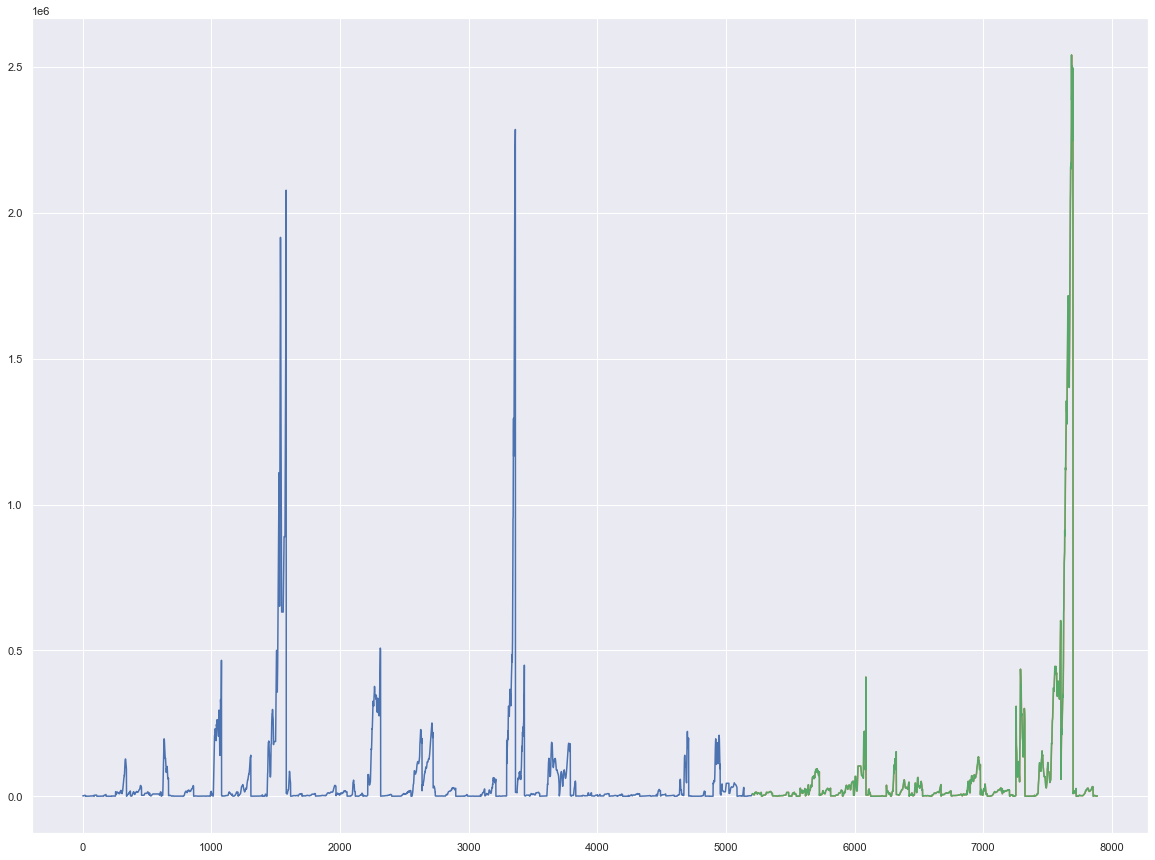

In [40]:
# split into train and test sets
X = df_lagged.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

geht das überhaupt über alle Länder? Sind doch eigentlich eine Zeitreihe pro Land und damit einzeln zu betrachten, oder?

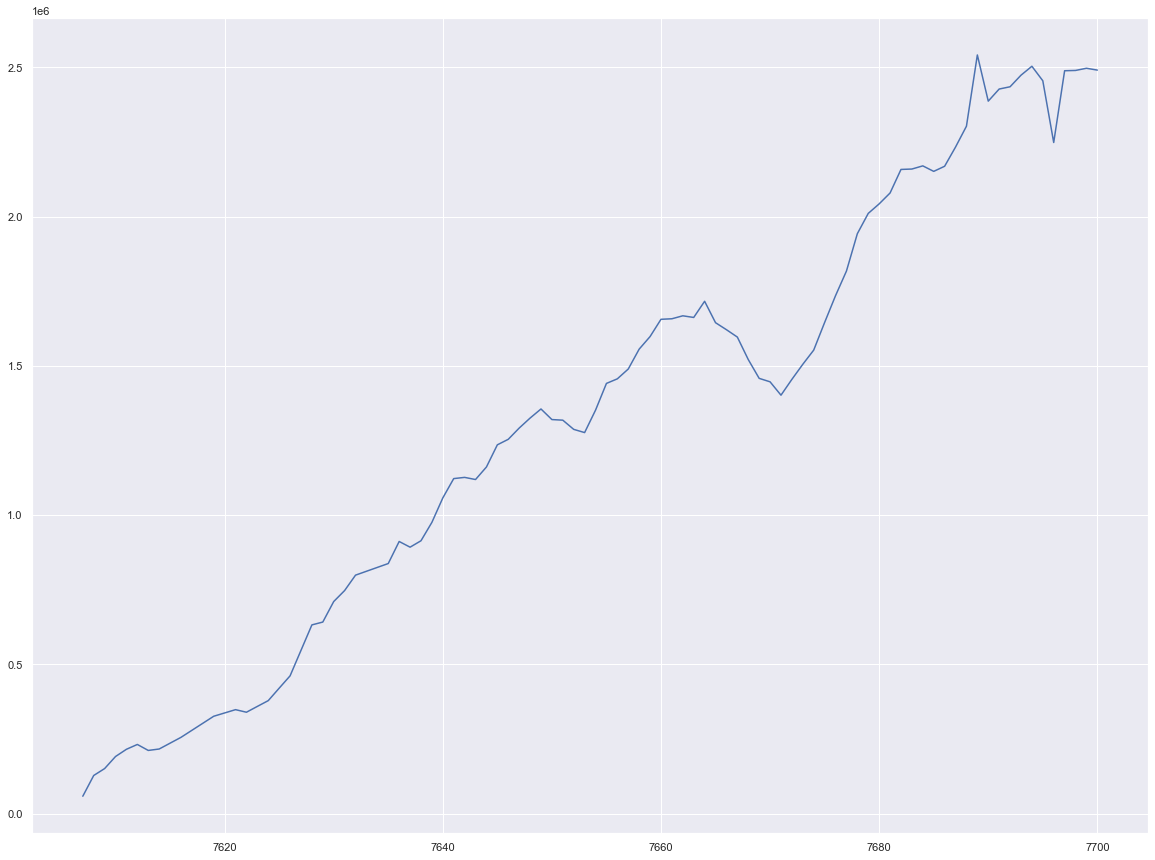

In [70]:
#Baseline model for United states data only:
baseline_us = df_time_m[df_time_m.country == 'United States']
baseline_us = baseline_us[['date', 'daily_vaccinations']]
baseline_us.head()


#plt.plot(baseline_us['daily_vaccinations'])
#plt.show();

#### Define the Supervised Learning Problem

The first step is to load the dataset and create a lagged representation. That is, given the observation at t-1, predict the observation at t+1.

In [63]:
# Create lagged dataset
df_time_wo_detrend_us = baseline_us[['daily_vaccinations']]
df_lagged_us = df_time_wo_detrend_us.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend_us.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend_us.columns]
    
    df_lagged_us = pd.concat((df_lagged_us, shifted), axis=1)
df_lagged_us = df_lagged_us.dropna()
df_lagged_us.head(10)

,daily_vaccinations,daily_vaccinations_lag1
7608,127432.0,57909.0
7609,150606.0,127432.0
7610,191001.0,150606.0
7611,215238.0,191001.0
7612,231396.0,215238.0
7613,211379.0,231396.0
7614,216147.0,211379.0
7615,235685.0,216147.0
7616,255223.0,235685.0
7617,278776.0,255223.0


Test MSE: 8246182421.094


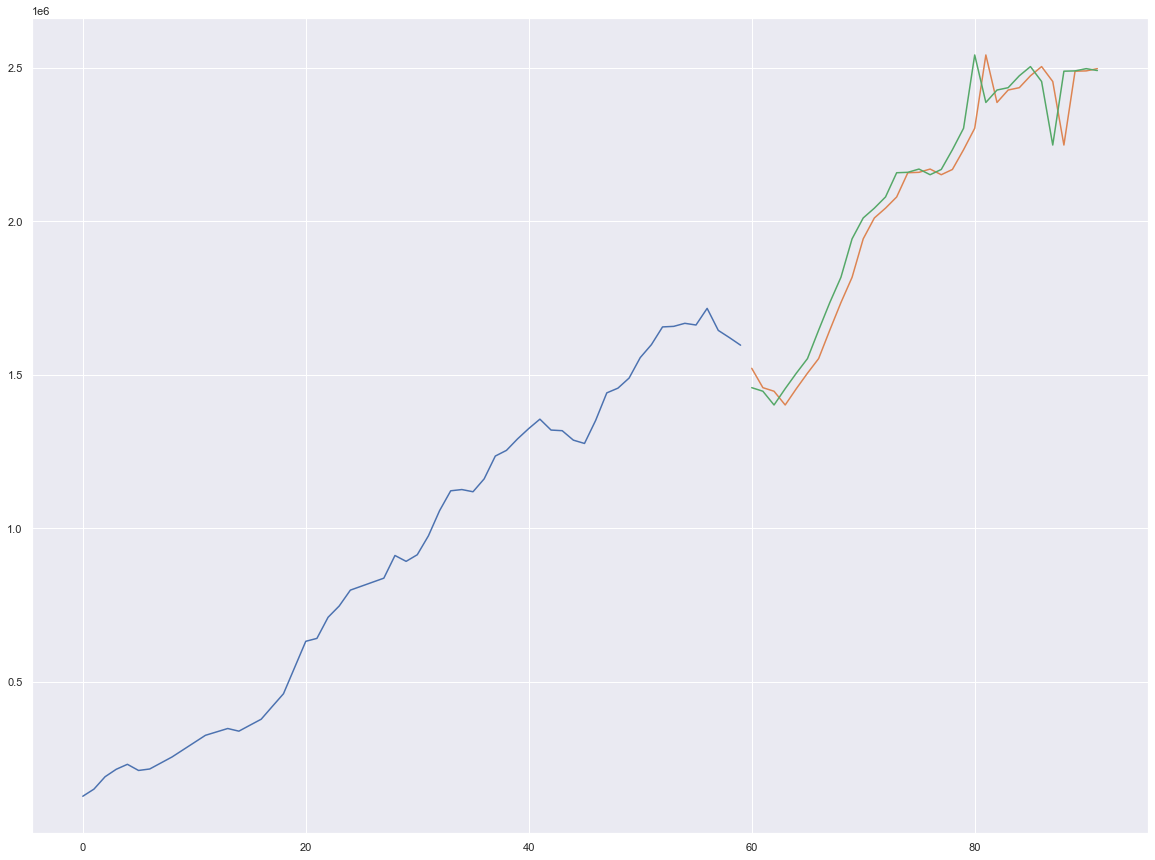

In [64]:
# split into train and test sets
X = df_lagged_us.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()
# label einfügen!

green line = test data
orange line = prediction

The plot shows the trainings dataset and the diverging predictions from the expected values from the test dataset.

It shows ???
(?The plot shows that the model is 1-step behind reality.?)



### Models for predicting vaccinations progress United States

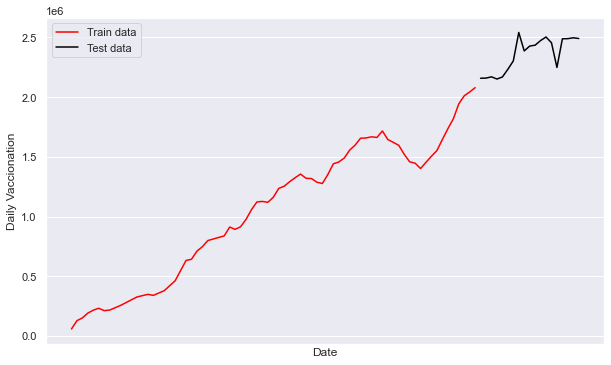

In [72]:
# Split data into train and test set
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us = df_time_m_us[['daily_vaccinations']]
df_arima = df_time_m_us['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

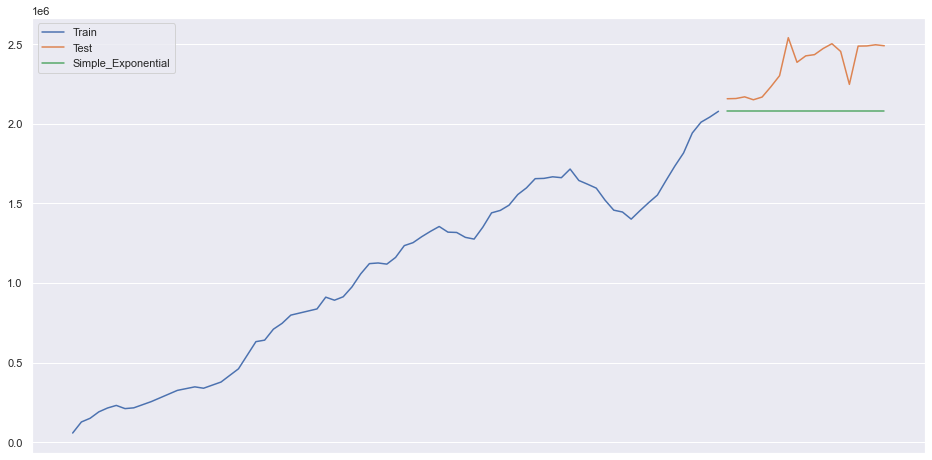

Simple Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0


In [73]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

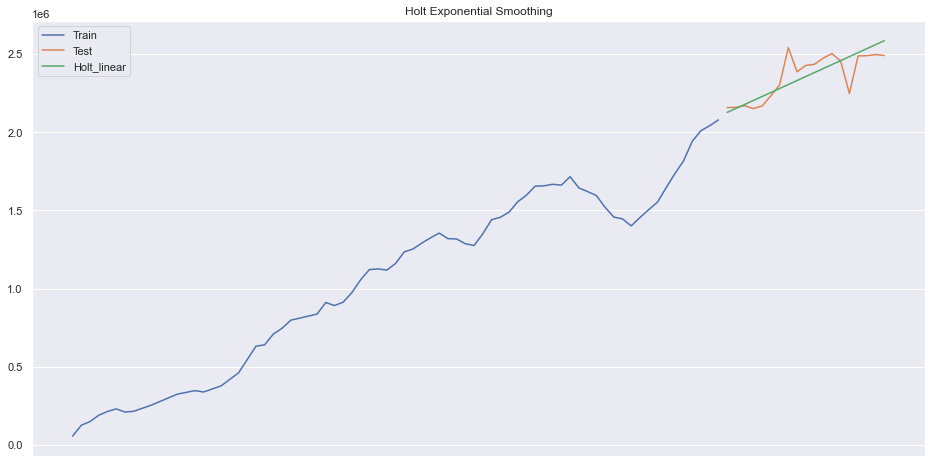

Holt’s Exponential Smoothing RMS :- 90480.675 & Smoothing Level :- 0.55 & Smoothing Slope :- 1.0


In [74]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1832.499, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2205.294, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1854.871, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2149.893, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2313.826, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1809.395, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1810.711, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1808.797, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1807.037, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1806.820, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1809.149, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
T

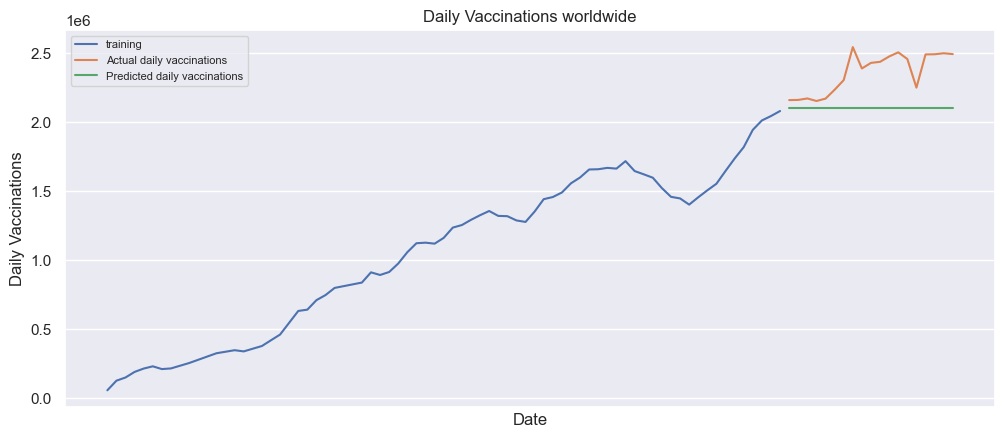

Auto-Arima RMSE :- 289969.341


In [75]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

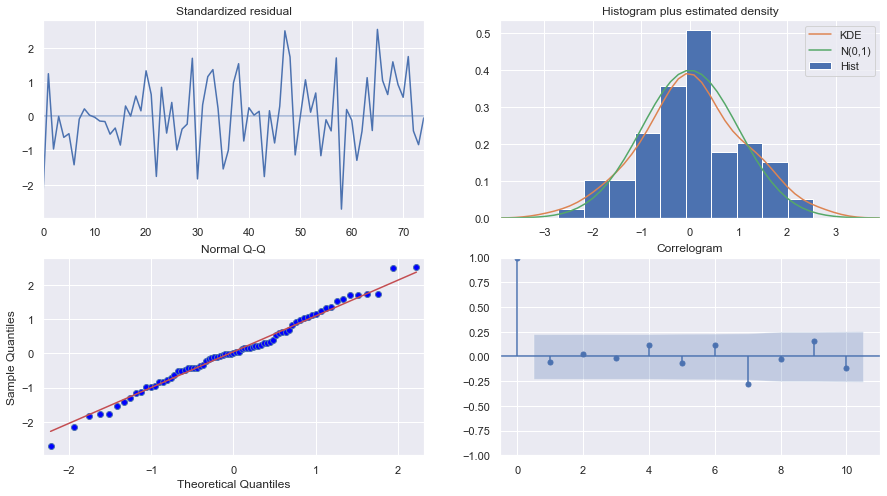

In [76]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [77]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  289969.341
Simple Exponential Smoothing:  312111.348
Holt’s Exponential Smoothing:  90480.675


From the three models we trained the Holt's Exponential Smoothing reached the smallest RSME but all models are not really satisfying.

### Models for predicting vaccinations progress worldwide

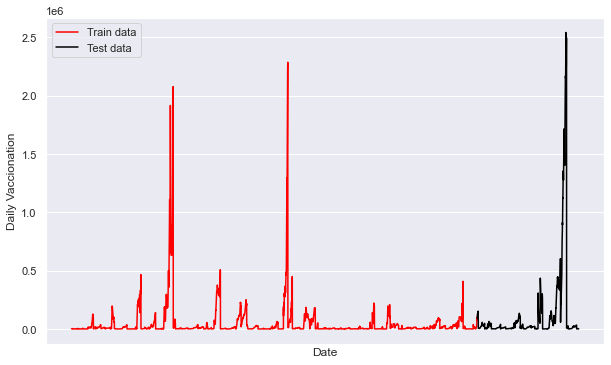

In [41]:
# Split data into train and test set
df_arima = df_time_m['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

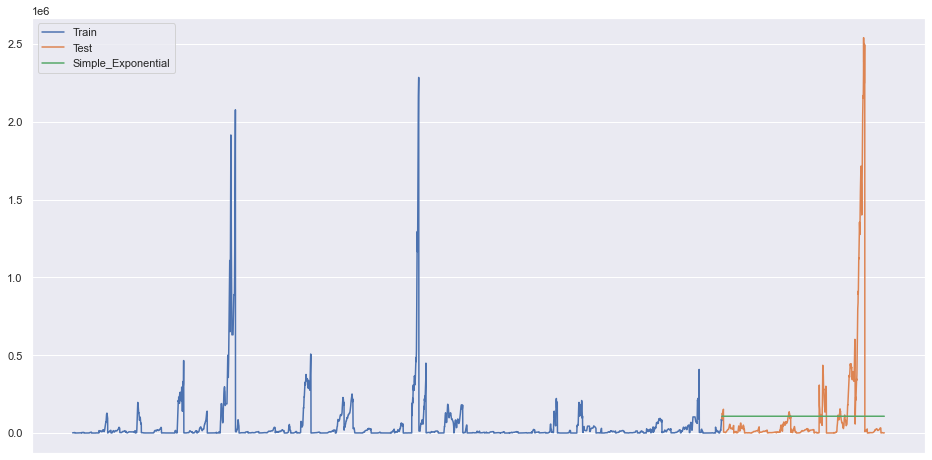

Simple Exponential Smoothing RMS :- 360897.876 & Smoothing Level :- 1.0


In [42]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

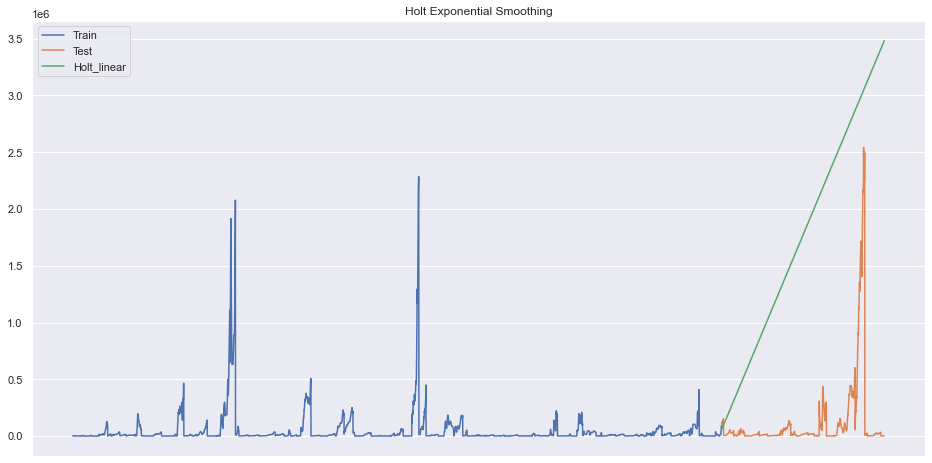

Holt’s Exponential Smoothing RMS :- 1896151.206 & Smoothing Level :- 0.1 & Smoothing Slope :- 0.05


In [43]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=152545.450, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168636.202, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=152555.821, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=164338.655, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=169163.906, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=152543.130, Time=2.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=152544.426, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=152539.765, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=152537.321, Time=0.34 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=152539.294, Time=0.49 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=152541.639, Time=1.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=152547.690, Time=0.21 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 6.377 seconds
                               SARIMAX Results                                
Dep. Variable:              

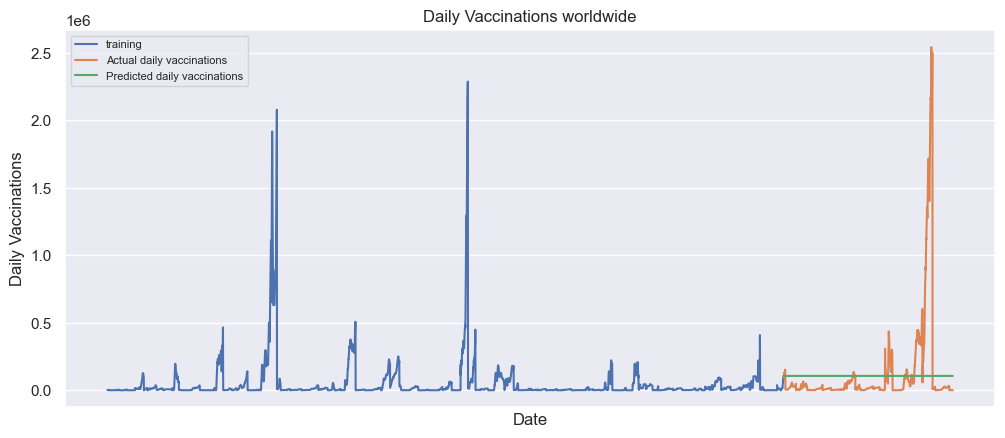

Auto-Arima RMSE :- 360964.969


In [44]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

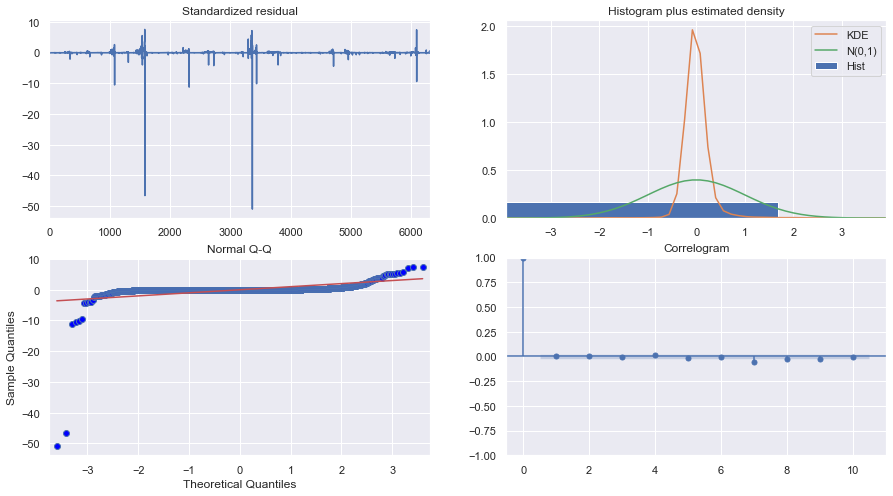

In [45]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Evaluation of the models
to evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [46]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  360964.969
Simple Exponential Smoothing:  360897.876
Holt’s Exponential Smoothing:  1896151.206


From the three models we trained the Simple Exponential Smoothing reached the smallest RSME. (Woran liegt das? Wir haben keinen Trend und keine seasonality und damit z.B. Holt's nicht geeignet?)

In [78]:
## Model with different features